<a href="https://colab.research.google.com/github/ELVAN13091999/my-first-binder/blob/main/Data_Science_In_Health_Care_Using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spreading Covid19 in Indonesia by Advanced prognostication using Neural Networks   
Personal Project By Elvan Vensiando

Special thanks to IBM Corporation and MIT for providing free online courses in cognitiveclass.ai

Special thanks to Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]

-> Import Library, Download Data and Preliminary Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
#firstly, upload data to file
covid_word = pd.read_csv('owid-covid-data.csv')
covid_word

FileNotFoundError: ignored

-> Let's recognized types of data correctly

In [ ]:
covid_word.info()

As we can see the first 4th columns and test_units are object, Let's investigate them

In [ ]:
fields = ['iso_code', 'continent', 'location', 'tests_units']
covid_word[fields]

-> Let's investigate detail of the fields data

In [ ]:
covid_word[fields]

In [ ]:
fields = ['iso_code', 'continent', 'location', 'tests_units']
covid_word[fields] = covid_word[fields].astype('category')
covid_word.loc[:, 'date'] = pd.to_datetime(covid_word['date'])
covid_word[fields].describe()

assigned fields to categorical fields because of many repetitions

-> Let's show a list of countries

In [ ]:
covid_word['location'].cat.categories

-> Let's investigate the dynamics of new cases of COVID-19 for a separate country. We will use Indonesia for saving models and further forecast. Let's use a pandas filter to do this.

In [ ]:
covid_word.index = covid_word['date']

c_covid = covid_word[covid_word['location'] == "Indonesia"]
c_covid

-> 
Let's choose the fields 'new_cases', 'new_cases_smoothed' for forecasting. First of all, we should visualize this data.

In [ ]:
import matplotlib.pyplot as plt
fields = ['new_cases', 'new_cases_smoothed']
c_covid[fields].plot()
plt.show()

As we can see, there are large fluctuations in the new cases plot. Let's try to make a forecast for these waves. First of all, we should delete missing data using pandas.DataFrame.dropna()

In [ ]:
c_covid = c_covid[fields].dropna()
c_covid

-> If we want to make a forecast of time series, the only assumption that can be made - the data for today depends on the previous days values. To check for dependencies, it is necessary to perform a correlation analysis between them. This requires:
 
1.   duplicating the time series of data and moving it
2.   vertically down for a certain number of days (lag)
3.   deleting the missing data at the beginning and end (they are formed by vertical shift (pandas.DataFrame.shift())
4.   calculating the correlation coefficient between the obtained series.



Since this operation should be performed for different values of the lag, it is convenient to create a separate function:

In [ ]:
def lag_correlation_ts(y, x, lag):
    """
    Lag correlation for 2 DateSeries
    :param y: fixed
    :param x: shifted
    :param lag: lag for shifting
    :return: DataFrame of lags correlation coefficients
    """
    r = [0] * (lag + 1)
    y = y.copy()
    x = x.copy()
    y.name = "y"
    x.name = "x"

    for i in range(0, lag + 1):
        ds = y.copy().to_frame()
        ds = ds.join(x.shift(i), how='outer')
        r[i] = ds.corr().values[0][1]
    r = pd.DataFrame(r)
    r.index.names = ['Lag']
    r.columns = ['Correlation']
    return r

-> Let's create a target DataSet.

In [ ]:
y_dataset = c_covid['new_cases']
y_dataset

-> Let's test a 30-day lag.

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format
l = pd.DataFrame(lag_correlation_ts(y_dataset, y_dataset, 30)) #For time series we should use y_Dataset like input and output
print(l)
l.plot()

As we can see, there are some waves observed in the lag plot. You can see from the table that there is a peak for every seventh day. (Maximum lags are: 7, 14, 21, etc. days). This is due to the weekly cycle.

Any forecast model can be shown as a black box of input-target type. The target should be the data of the original time series, and the input should be the values for the previous days.

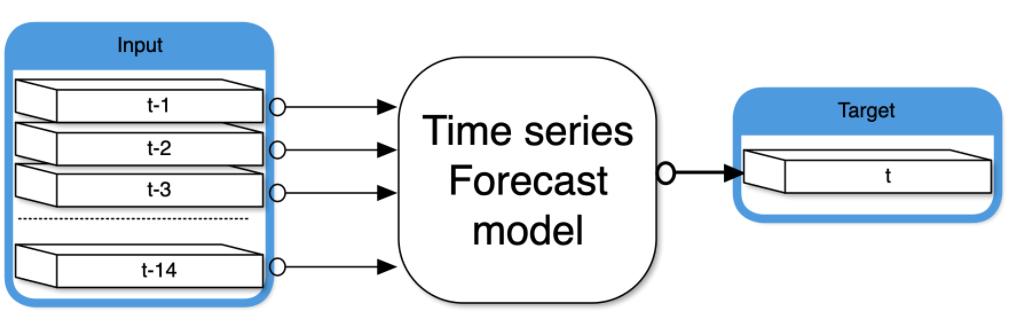

-> To automate this process, let's make a universal function for time series transformation to create this DataSet.

In [ ]:
def series_to_supervised(in_data, tar_data, n_in=1, dropnan=True, target_dep=False):
    """
    Transformation into a training sample taking into account the lag
     : param in_data: Input fields
     : param tar_data: Output field (single)
     : param n_in: Lag shift
     : param dropnan: Do destroy empty lines
     : param target_dep: Whether to take into account the lag of the input field. If taken into account, the input will start with a lag 1
     : return: Training sample. The last field is the source
    """

    n_vars = in_data.shape[1]
    cols, names = list(), list()

    if target_dep:
        i_start = 1
    else:
        i_start = 0
    for i in range(i_start, n_in + 1):
        cols.append(in_data.shift(i))
        names += [('%s(t-%d)' % (in_data.columns[j], i)) for j in range(n_vars)]

    if target_dep:
        for i in range(n_in, -1, -1):
            cols.append(tar_data.shift(i))
            names += [('%s(t-%d)' % (tar_data.name, i))]
    else:
        # put it all together
        cols.append(tar_data)
        names.append(tar_data.name)
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

As mentioned above, when forecasting time series, the input and output fields are the same, only shifted by the lag.

In [ ]:
dataset = series_to_supervised(pd.DataFrame(y_dataset), y_dataset, 14) ##target data based previous days
dataset

-> As we can see, the first and last columns contain the same target data. Now we should create input (X) and output (Y) DataSets for forecasting models.

In [ ]:
col = dataset.columns
X, Y = dataset[col[1:-1]], dataset[col[-1]]
print("Input: ", X.columns)
print("Target:", Y.name)

-> After that, we should normalize all the data. To do this, the sklearn.preprocessing.MinMaxScaler module should be used. It allows us to normalize fit_transform() and convert back all the data easily: fit_transform().

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_x = scaler_x.fit_transform(X)
scaled_y = scaler_y.fit_transform(Y.values.reshape(-1, 1))

After that, we are going to form training and test DataSets using sklearn.model_selection.train_test_split(). We will make them at the ratio of 70/30. Without shuffling. It means, that test samples are located in the end of X and Y DataSets.

Input normalized DataSets: X_train, X_test

Target normalized DataSets: y_train, y_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_x, scaled_y, test_size=0.3, shuffle=False)

All the data is normalized now. However, in order to compare to results, we need real scale data of the training and test DataSet:

In [ ]:
res_train = scaler_y.inverse_transform(y_train).flatten()
res_test = scaler_y.inverse_transform(y_test).flatten()

Target real scale DataSets: res_train, res_test.

# Three type of models. A Linear regression, a Multilayer Neural Network with Backpropagation and a Long Short-Term Memory Neural Network. 

-> Let's create a LinearRegression():

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

After that, our model should be fitted on the training DataSet. Regardless of the model type, the function fit() is used to do this.

In [ ]:
regressor.fit(X_train, y_train)

-> We can test it on the test DataSet and use it for prognostication.

In [ ]:
y_pred_test_ln = regressor.predict(X_test)
y_pred_test_ln = scaler_y.inverse_transform(y_pred_test_ln).flatten()

-> Let's analyze the results accuracy using sklearn.metrics.

In [ ]:
from sklearn import metrics
print("Correlation train", regressor.score(X_train, y_train))
print("Correlation test", regressor.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test_ln))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test_ln))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_ln)))

The modern approach to the establishment of complex functional dependencies is the use of neural networks. A classical neural network is a multilayer neural network with back propagation.

To do this, we will use the keras framework. First of all, we should create a Neural Network model as a separate function.

A neural network is a sequence of layers. The function Sequential() is used to create a network.

Let's create a network that consists of 2 hidden layers. Each of which consists of 100 neurons. keras.layers.Dense().

To avoid retraining problems, we will use additional layers keras.layers.Dropout().

The output layer will consist of one neuron, since we have only one value at the output.

The model should be compiled for fitting and predicting: keras.Model.compile().

-> Let's make a Multilayer Neural Network with Backpropagation 

In [ ]:
def BP_model(X):
    """
    Multilayer neural network with back propagation.
    :param X: Input DataSet
    :return: keras NN model
    """
    # create model
    model = Sequential() 
    model.add(Dense(100, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Once the model function is built, it is necessary to create a neural network directly and specify the learning parameters: keras.wrappers.scikit_learn.KerasRegressor(). Also we should define the number of fitting epoch and batch size.

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
epochs = 1000

batch_size=int(y_train.shape[0]*.1)

estimator = KerasRegressor(build_fn=BP_model, X=X_train, epochs=epochs, batch_size=batch_size, verbose=1)

Now, let’s train our model for 1000 epochs. It should be noted that the fitting process is very slow. Therefore, we saved our fitted model to a file. To save time, we will upload the fitted model. If we like, we can leave the parameter fitting on True to refit the model. If you like, we can leave the parameter fitting_save on True to resave the model.

In [ ]:
fitting = True
fitting_save = True

import pickle

if fitting:
    history=estimator.fit(X_train,y_train, validation_data=(X_test,y_test)) # Fitting model
    if fitting_save:
        # Save model
        estimator.model.save('BP_saved_model.h5')
        print("Saved model to disk")
        with open('history.pickle', 'wb') as f:
            pickle.dump(history.history, f)
# load model 
from keras.models import load_model

# Instantiate the model as you please (we are not going to use this)
estimator = KerasRegressor(build_fn=BP_model, X=X_train, epochs=epochs, batch_size=batch_size, verbose=1)
# This is where you load the actual saved model into a new variable.
estimator.model = load_model('BP_saved_model.h5')    
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)
print("Loaded model from disk")

-> Let's show the loss and validation loss dynamics.

In [ ]:
plt.figure()
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.plot(history.history['acc'], label='acc')
#plt.plot(history.history['val_acc'], label='acc test')
plt.legend()
plt.show()

As we can see, a Neural Network is well-fitted and no overfitting is observed. Let's calculate a prediction of the training (res_train_ANN) an test (res_test_ANN) sets.

-> Let's calculate a forecast and make an inverse normalization to real scale.

In [ ]:
res_tr=estimator.predict(X_train)
res_ts=estimator.predict(X_test)
res_train_ANN=scaler_y.inverse_transform(res_tr.reshape(-1, 1)).flatten()
res_test_ANN=scaler_y.inverse_transform(res_ts.reshape(-1, 1)).flatten()

Let's compare the accuracy of a Linear Regression and a Neural Network.

In [ ]:
print("Correlation train", np.corrcoef(res_train, res_train_ANN)[0,1])
print("Correlation test", np.corrcoef(res_test, res_test_ANN)[0,1])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, res_test_ANN))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, res_test_ANN))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, res_test_ANN)))

We got slightly better results for a Neural Network than for a Linear Regression.

Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points, but also entire sequences of data (such as speech, video or time series).

In case of time series, the neural network has one input and one output. However, there should be a vector of time series values for the previous time period on the input.

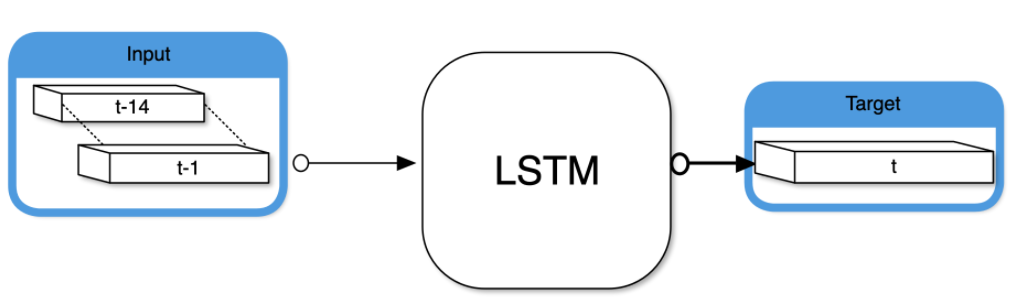

-> Let's Long Short-Term Memory Neural Network.
To do this, we should transform input DataSets into 3D shape.

In [ ]:
train_x_LSTM = X_train.reshape((X_train.shape[0], 1, 14))
test_x_LSTM = X_test.reshape((X_test.shape[0], 1, 14))

-> Let's create an LSTM Neural Network consisting of one LSTM layer and one BP layer like in the previous case. As you can see, in this case our NN will consist of 7 LSTM and 7 BP neurons only.

In [ ]:
from keras.layers import LSTM

batch_size=int(y_train.shape[0]*.1)
model = Sequential()
model.add(LSTM(7, input_shape=(train_x_LSTM.shape[1], train_x_LSTM.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(7, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1])) #activation='sigmoid'
model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(loss='mae', optimizer='adam')


-> All subsequent steps of learning, storing, reading and predicting are similar to the ones we used with the previous neural network. We can see that only 400 epochs are enough for an LSTM.

In [ ]:
fitting = True
fitting_save = True
epochs = 400

if fitting:
    history = model.fit(train_x_LSTM, y_train, epochs=epochs, batch_size=batch_size, validation_data=(test_x_LSTM, y_test), verbose=1, shuffle=False)    
    if fitting_save:
    # serialize model to JSON
        model_json = model.to_json()
        with open("LSTM_model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("LSTM_model.h5")
        print("Saved model to disk")
        with open('history_LSTM.pickle', 'wb') as f:
            pickle.dump(history.history, f)
# load model  
from keras.models import model_from_json
json_file = open('LSTM_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("LSTM_model.h5")        
with open('history_LSTM.pickle', 'rb') as f:
    history = pickle.load(f)
print("Loaded model from disk")

-> Let's plot the dynamic of loss and val loss like in the previous case.

In [ ]:
plt.figure()
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.show() 

-> Let's calculate our forecast.

In [ ]:
res_tr_LSTM = model.predict(train_x_LSTM)
res_ts_LSTM = model.predict(test_x_LSTM)
res_train_LSTM=scaler_y.inverse_transform(res_tr_LSTM).flatten()
res_test_LSTM=scaler_y.inverse_transform(res_ts_LSTM).flatten()

-> Let's calculate accuracy

In [ ]:
print("Correlation train", np.corrcoef(res_train, res_train_LSTM)[0,1])
print("Correlation train", np.corrcoef(res_test, res_test_LSTM)[0,1])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, res_test_LSTM))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, res_test_LSTM))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, res_test_LSTM)))


-> As we can see, the forecast results of the test data set are much better than ones of the previous models. Let's visualize these 3 results:

In [ ]:
res_pred_test_ln = pd.Series(y_pred_test_ln, name = 'Predicted test Linear Model')
res_pred_test_ANN = pd.Series(res_test_ANN, name = 'Predicted test ANN')
res_pred_test_LSTM = pd.Series(res_test_LSTM, name = 'Predicted test LSTM')

df_2 = pd.DataFrame({'Actual test': res_test, 'Linear Model': res_pred_test_ln, 'ANN Model': res_pred_test_ANN,  'LSTM Model': res_pred_test_LSTM,})
df_2.index = dataset.index[len(dataset)-len(res_test):]
df_2.plot()
plt.show()

Conclusion 
As we can see, an LSTM model makes a perfect forecast. A Linear Regression is the fastest forecasting model.
